## PUBG Introduction

PlayerUnknowns Battlegrounds is a Battle Royal game where up to 100 players compete to be the last man or team standing on maps ranging from 8kmx8km to 4kmx4km. The game starts by players jumping out of a plane and parachuting down to the ground where by the players then loot for weapons and useful items in their quest to win the coveted Chicken Dinner.

Players don't just have to worry about being killed by other players, they also need to keep one step ahead of the ever decreasing blue circles which corral the players into the battle. Outside of the "safe zone" players will take damage at increasing rates. There is also a random "Red Zone", whereby various points on the map are targeted by an artillery strike which can be deadly for the players caught out in the open.

![alt text](PUBG.jpg "Title")

### Chanllenge

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

### Data Dictionary

- __DBNOs__ - Number of enemy players knocked. <br>
- __assists__ - Number of enemy players this player damaged that were killed by teammates.<br>
- __boosts__ - Number of boost items used.<br>
- __damageDealt__ - Total damage dealt. Note: Self inflicted damage is subtracted.<br>
- __headshotKills__ - Number of enemy players killed with headshots.<br>
- __heal__ - Number of healing items used.<br>
- __killPlace__ - Ranking in match of number of enemy players killed.<br>
- __killPoints__ - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)<br>
- __killStreaks__ - Max number of enemy players killed in a short amount of time.<br>
- __kills__ - Number of enemy players killed.<br>
- __longestKill__ - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.<br>
- __matchId__ - Integer ID to identify match. There are no matches that are in both the training and testing set.<br>
- __revives__ - Number of times this player revived teammates.<br>
- __rideDistance__ - Total distance traveled in vehicles measured in meters.<br>
- __roadKills__ - Number of kills while in a vehicle.<br>
- __swimDistance__ - Total distance traveled by swimming measured in meters.<br>
- __teamKills__ - Number of times this player killed a teammate.<br>
- __vehicleDestroys__ - Number of vehicles destroyed.<br>
- __walkDistance__ - Total distance traveled on foot measured in meters.<br>
- __weaponsAcquired__ - Number of weapons picked up.<br>
- __winPoints__ - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)<br>
- __groupId__ - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.<br>
- __numGroups__ - Number of groups we have data for in the match.<br>
- __maxPlace__ - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.<br>
- __winPlacePerc__ - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.<br>

In [1]:
# import packages
import os
import sys
import re
import gc
import tensorflow as tf

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, r2_score

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode()


import shap
import warnings
warnings.filterwarnings("ignore")



%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/user/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [2]:
train = pd.read_csv('train_V2.csv')

## Reduce the memory time

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    #print('{')
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
        col_type = str(df[col].dtype)
        if col_type == 'object':
            col_type = 'str'
        else:
            col_type = 'np.' + col_type    
        #print('\'' + col + '\':' + col_type + ',')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    #print('}')
    return df

In [4]:
print('Train dataset has {:,} rows  and {:,} columns'.format(train.shape[0], train.shape[1]))

Train dataset has 4,446,966 rows  and 29 columns


In [5]:
train.head()

Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00          0               0   
1        0.0045          0         11.04          0               0   
2        0.0000          0          0.00          0               0   
3        0.0000          0          0.00          0               0   
4        0.0000          0          0.00          0               0   

   walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0        244.80                1       1466        0.4444  
1       1434.00                5          0        0.6400  
2        161.80                2          0        0.7755  
3        202.70                3          0        0.1667  
4         49.75                2          0        0.1875  

[5 rows x 29 columns]

## Visulize the raw data

We would expect that the winning rate will follow the uniform distribution. This is simply because that for each game there could only be one winning place.

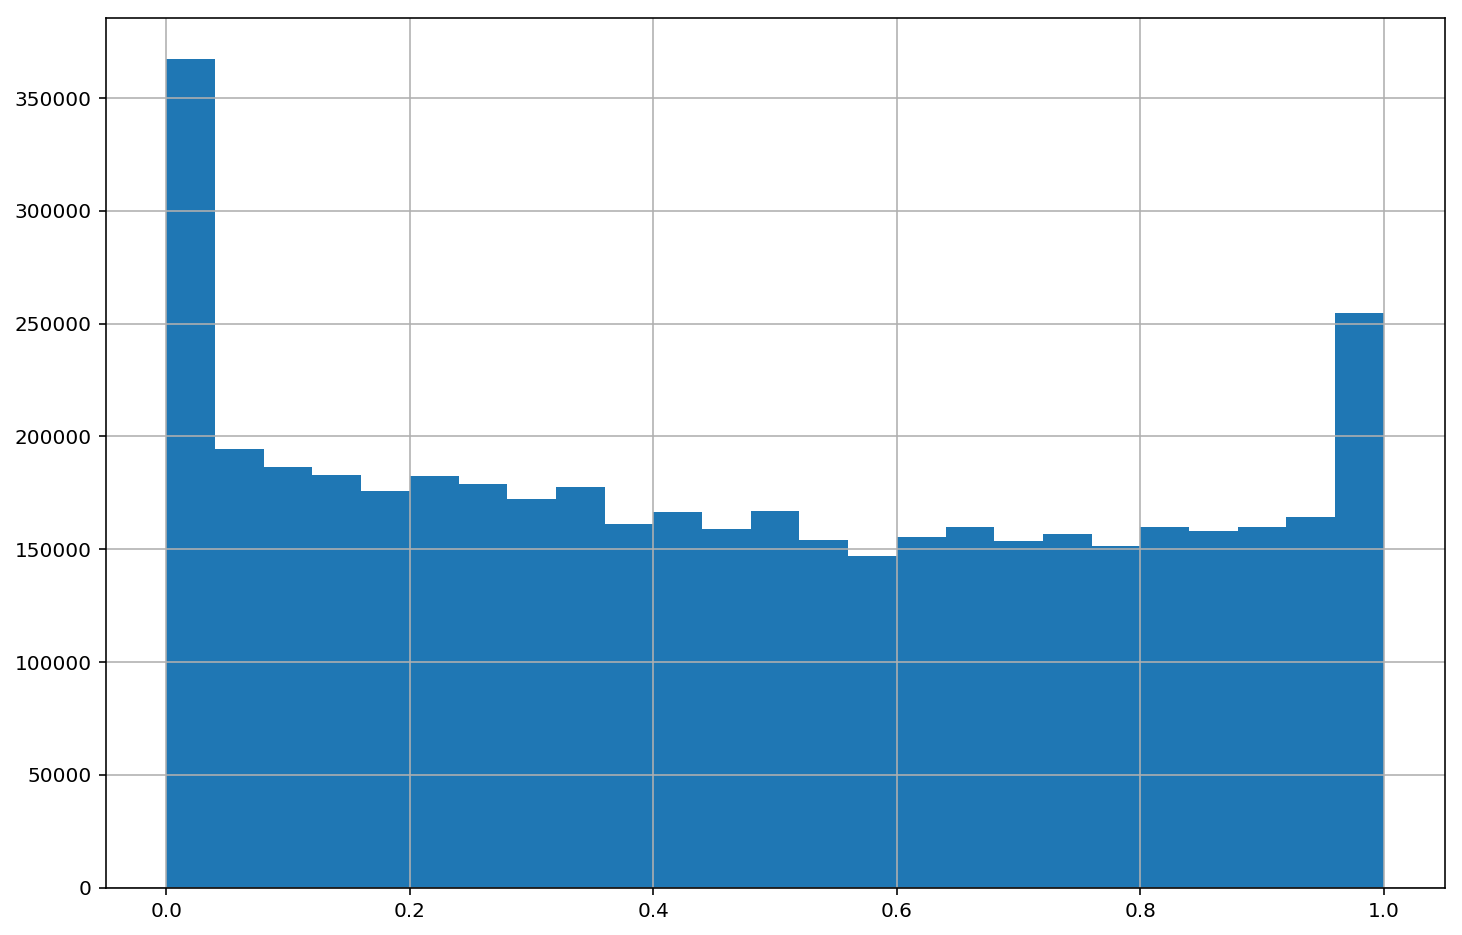

In [14]:
plt.figure(figsize = (12, 8))
train['winPlacePerc'].hist(bins=25)

The histogram plot somwehow shows a degree of skewness. 

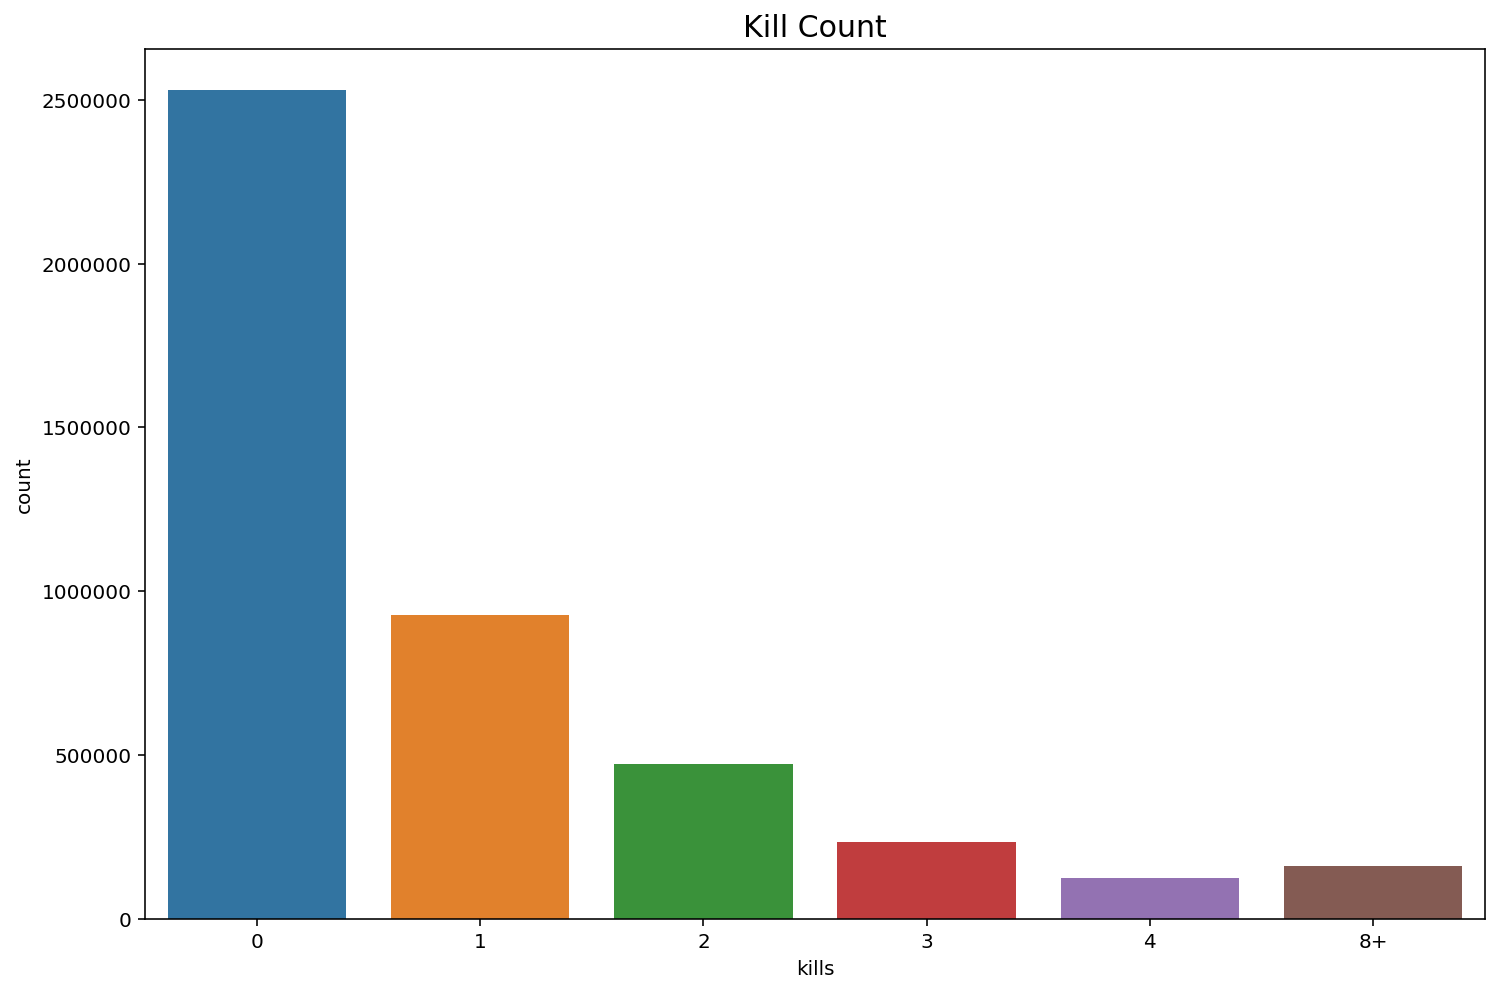

In [15]:
df =  train.copy()
df.loc[df['kills'] > df['kills'].quantile(0.95)] = "8+"
plt.figure(figsize = (12, 8))
sns.countplot(df['kills'].astype('str').sort_values())
plt.title('Kill Count', fontsize = 15)
plt.show()

It looks that most players have 0 kills during a game. However, kills doesn't necessarily imply winning placement. Let's take a look see how much damage they dealt in a match game.

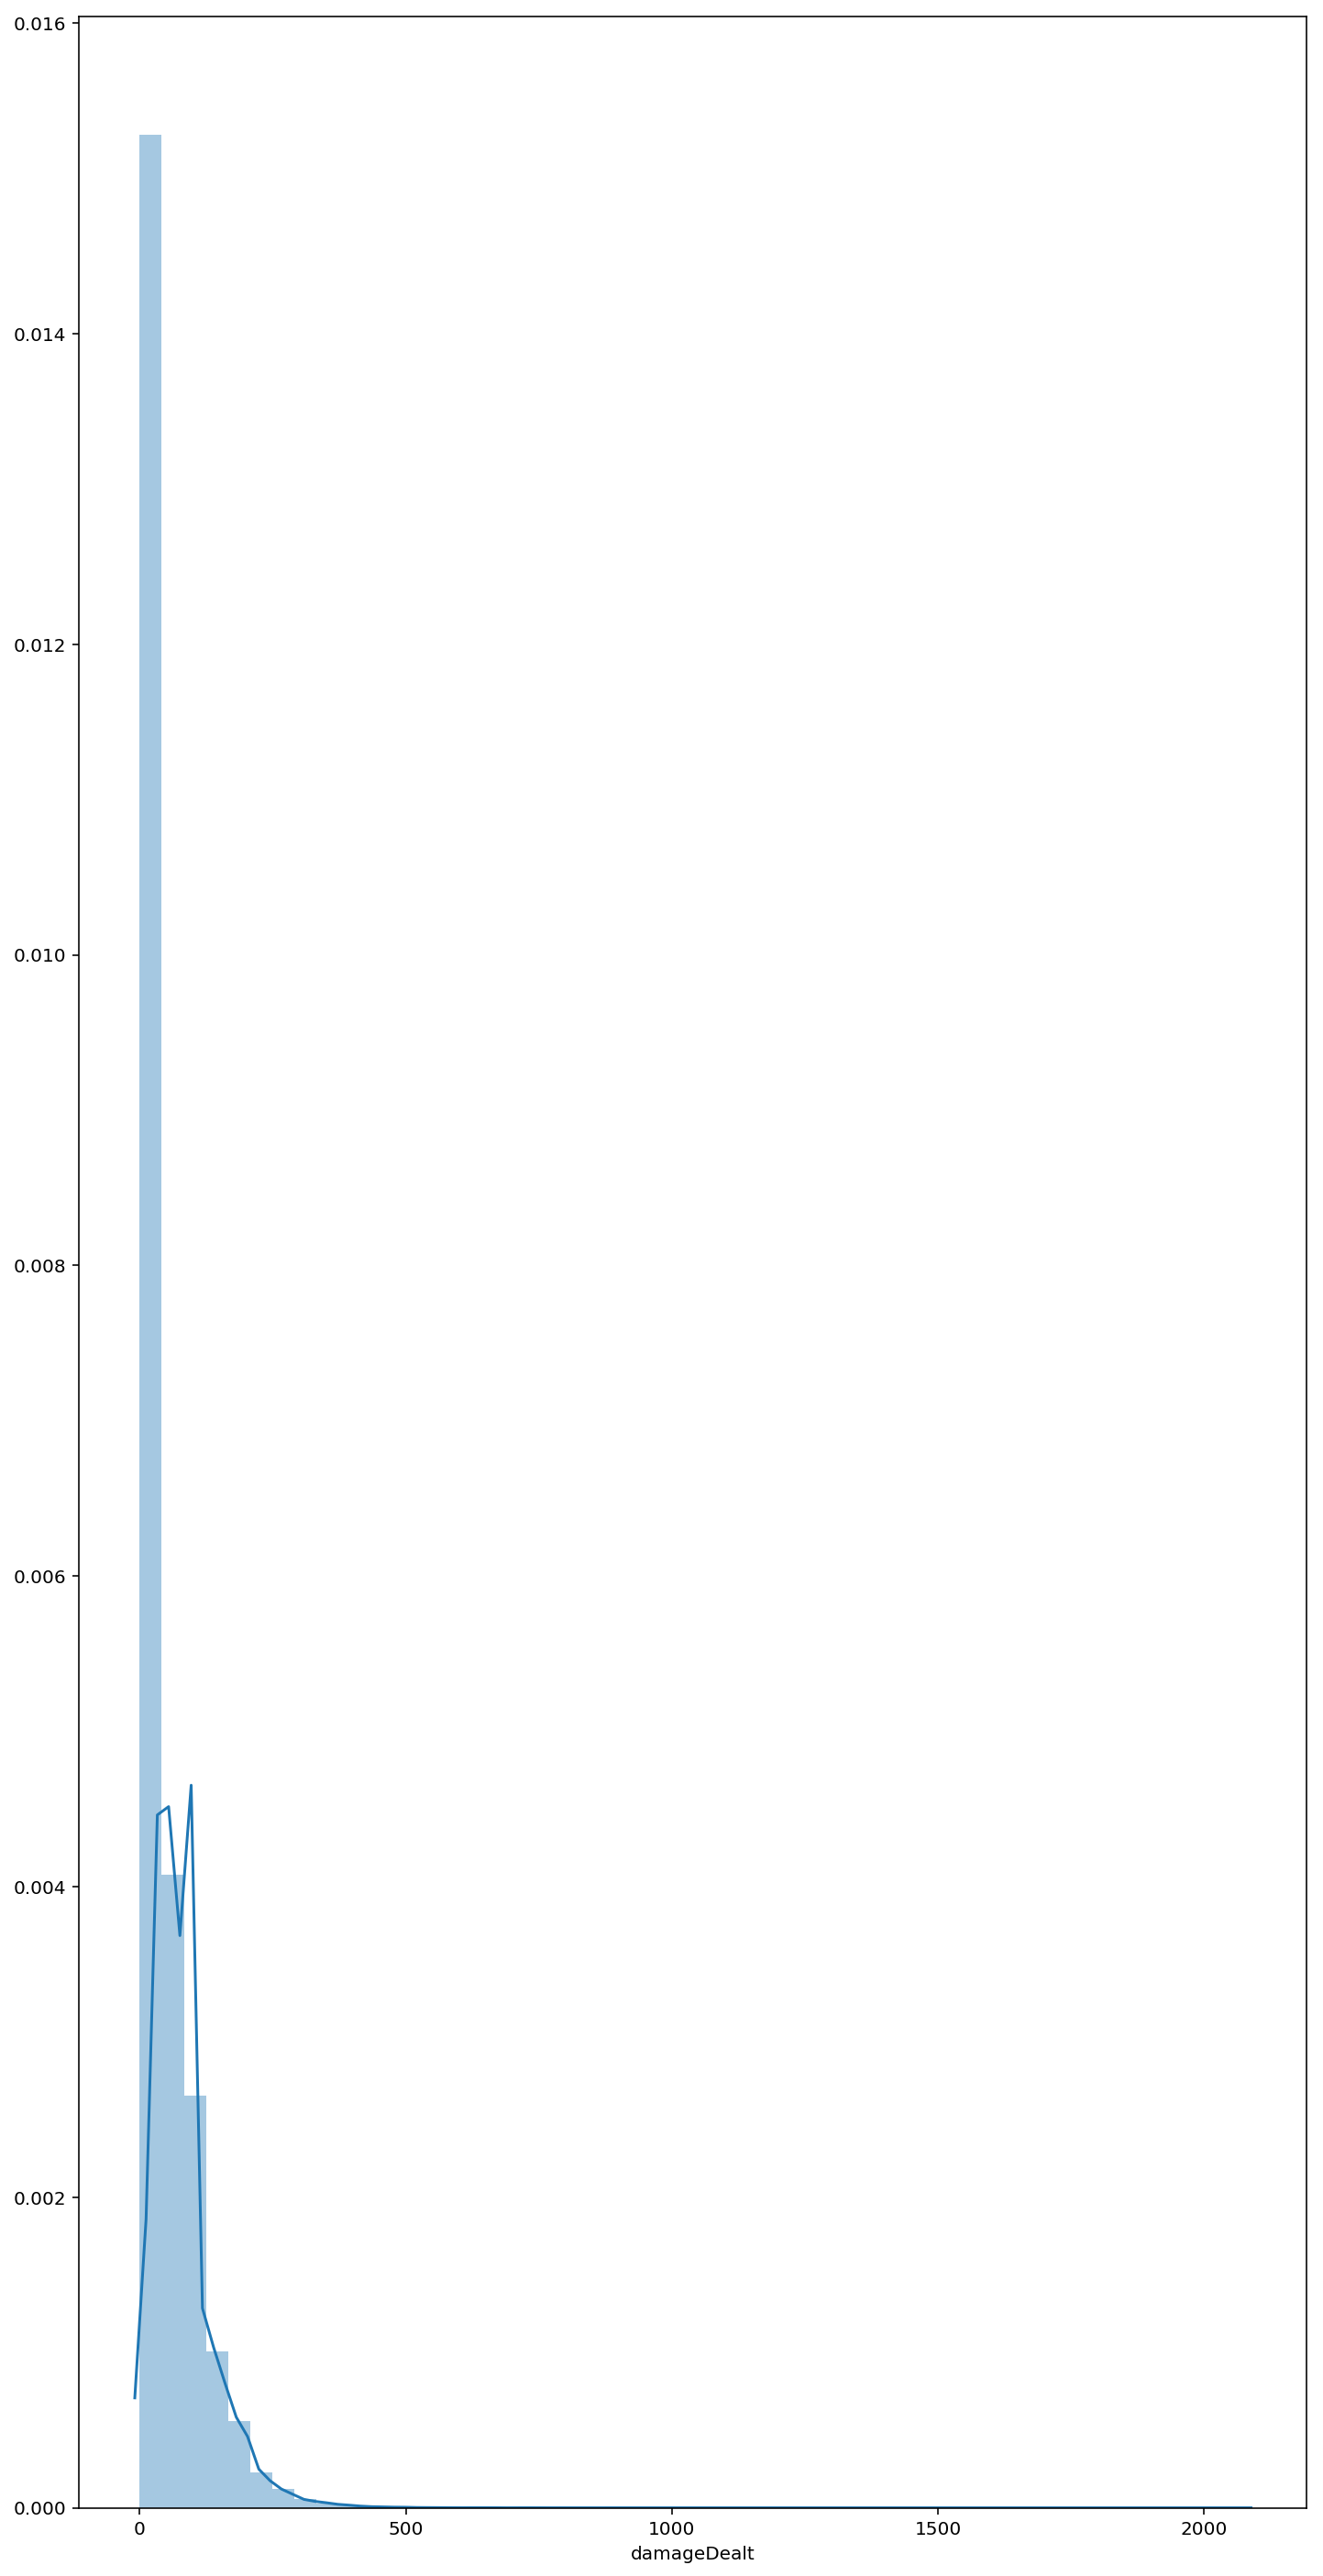

In [20]:
df =  train.copy()
plt.figure(figsize = (12, 25))
df = df[df['kills'] == 0]
sns.distplot(df.damageDealt)
plt.show()

It looks that for those people with 0 kill, the majority of people has no dame at all.

In [18]:
print("{} players ({:.2f}%) have won without a single kill!".format(len(df[df['winPlacePerc']==1]), 100*len(df[df['winPlacePerc']==1])/len(train)))

data1 = train[train['damageDealt'] == 0].copy()
print("{} players ({:.2f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

16666 players (0.37%) have won without a single kill!
4770 players (0.11%) have won without dealing damage!


Match type statistics

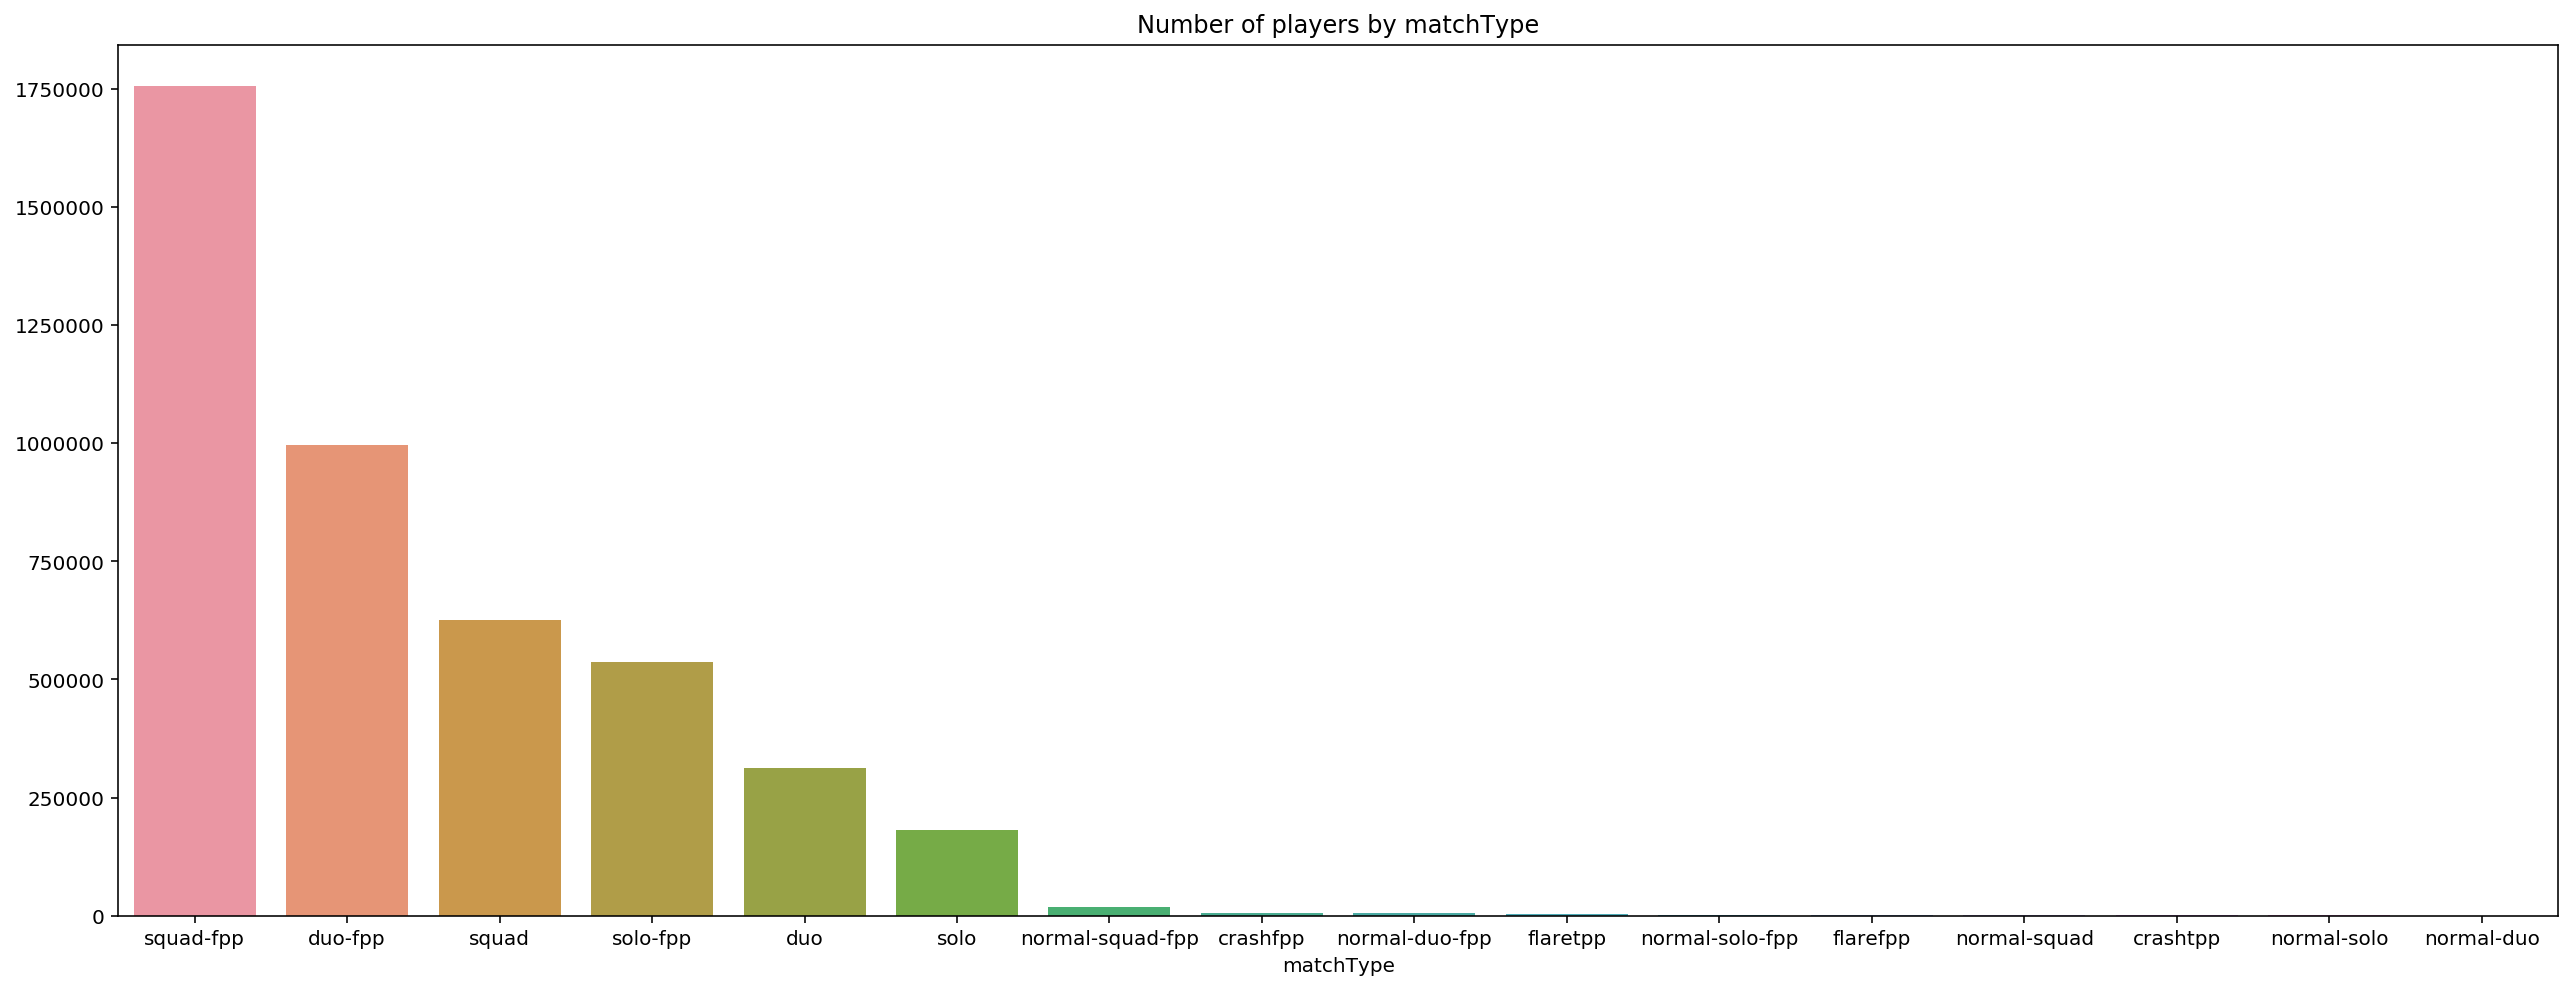

In [174]:
plt.rcParams['figure.figsize'] = 18,7
types = train.groupby("matchType").size().sort_values(ascending=False)
sns.barplot(x=types.index,y=types.values)
plt.title("Number of players by matchType")
plt.tight_layout()

In [176]:
def _min(x):
    return x.value_counts().values.min()
def _max(x):
    return x.value_counts().values.max()
def _avg(x):
    return x.value_counts().values.mean()
def _med(x):
    return np.median(x.value_counts().values)
def _num(x):
    return x.nunique()

stat = train.groupby('matchType').agg({
    "matchId": [np.size, _num, _min,_med,_max], 
    #np.size - number of players, _num - number of matches
    "groupId": [_min,_med,_max],
    "matchDuration": [min,np.median, max], 
    "maxPlace": [min,np.median,max],
    "numGroups":[min,np.median,max]
    }).sort_values(by=('matchId','size'),ascending=False)  
display(stat)

matchId                        groupId            \
                     size   _num _min  _med _max    _min _med _max   
matchType                                                            
squad-fpp         1756186  18576    5  96.0  100       1  3.0   31   
duo-fpp            996691  10620    7  95.0  100       1  2.0   72   
squad              626526   6658   18  95.0  100       1  3.0   28   
solo-fpp           536762   5679    1  96.0  100       1  1.0   64   
duo                313591   3356   38  95.0  100       1  2.0   16   
solo               181943   2297   11  95.0  100       1  1.0   21   
normal-squad-fpp    17174    358    6  56.0   95       1  4.0   74   
crashfpp             6287     73   20  92.0  100       1  2.0   10   
normal-duo-fpp       5489    158    7  26.0   98       1  2.0    7   
flaretpp             2505     29   57  89.0   97       1  3.0   18   
normal-solo-fpp      1682     96    2  14.0   58       1  1.0   10   
flarefpp              718      9   60  87.0   96       1  3.5   17   
normal-squad          516     16   13  29.0   99       1  4.0   10   
crashtpp              371      5   59  71.0   90       1  2.0    7   
normal-solo           326     23    6  11.0   47       1  1.0    7   
normal-duo            199     12    8  14.5   39       1  2.0    5   

                 matchDuration              maxPlace             numGroups  \
                           min median   max      min median  max       min   
matchType                                                                    
squad-fpp                  728   1402  2226        2     28   37         2   
duo-fpp                    840   1429  2202        4     48   51         4   
squad                     1048   1462  2218        7     28   34         6   
solo-fpp                     9   1439  2199        1     96  100         1   
duo                       1182   1521  2204       20     48   51        18   
solo                       950   1771  2237       11     96  100         1   
normal-squad-fpp           246   1889  2185        2     15   27         2   
crashfpp                   829    901   924       12     49   52        12   
normal-duo-fpp             152   1887  2181        3     31   50         1   
flaretpp                  1746   1873  1981       15     26   28        15   
normal-solo-fpp            133    898  1880        2     18   54         2   
flarefpp                  1792   1889  2031       16     26   29        16   
normal-squad               583   1246  1957        2      8   25         2   
crashtpp                   848    914   924       30     37   46        29   
normal-solo                317   1075  1823        6     13   44         4   
normal-duo                 807   1106  1793        5      8   20         4   

                              
                 median  max  
matchType                     
squad-fpp            27   37  
duo-fpp              46   51  
squad                27   33  
solo-fpp             93  100  
duo                  46   50  
solo                 92   99  
normal-squad-fpp     15   25  
crashfpp             46   52  
normal-duo-fpp       31   49  
flaretpp             24   27  
normal-solo-fpp      13   51  
flarefpp             25   29  
normal-squad          8   25  
crashtpp             33   44  
normal-solo          11   29  
normal-duo            8   20

Features Correlations

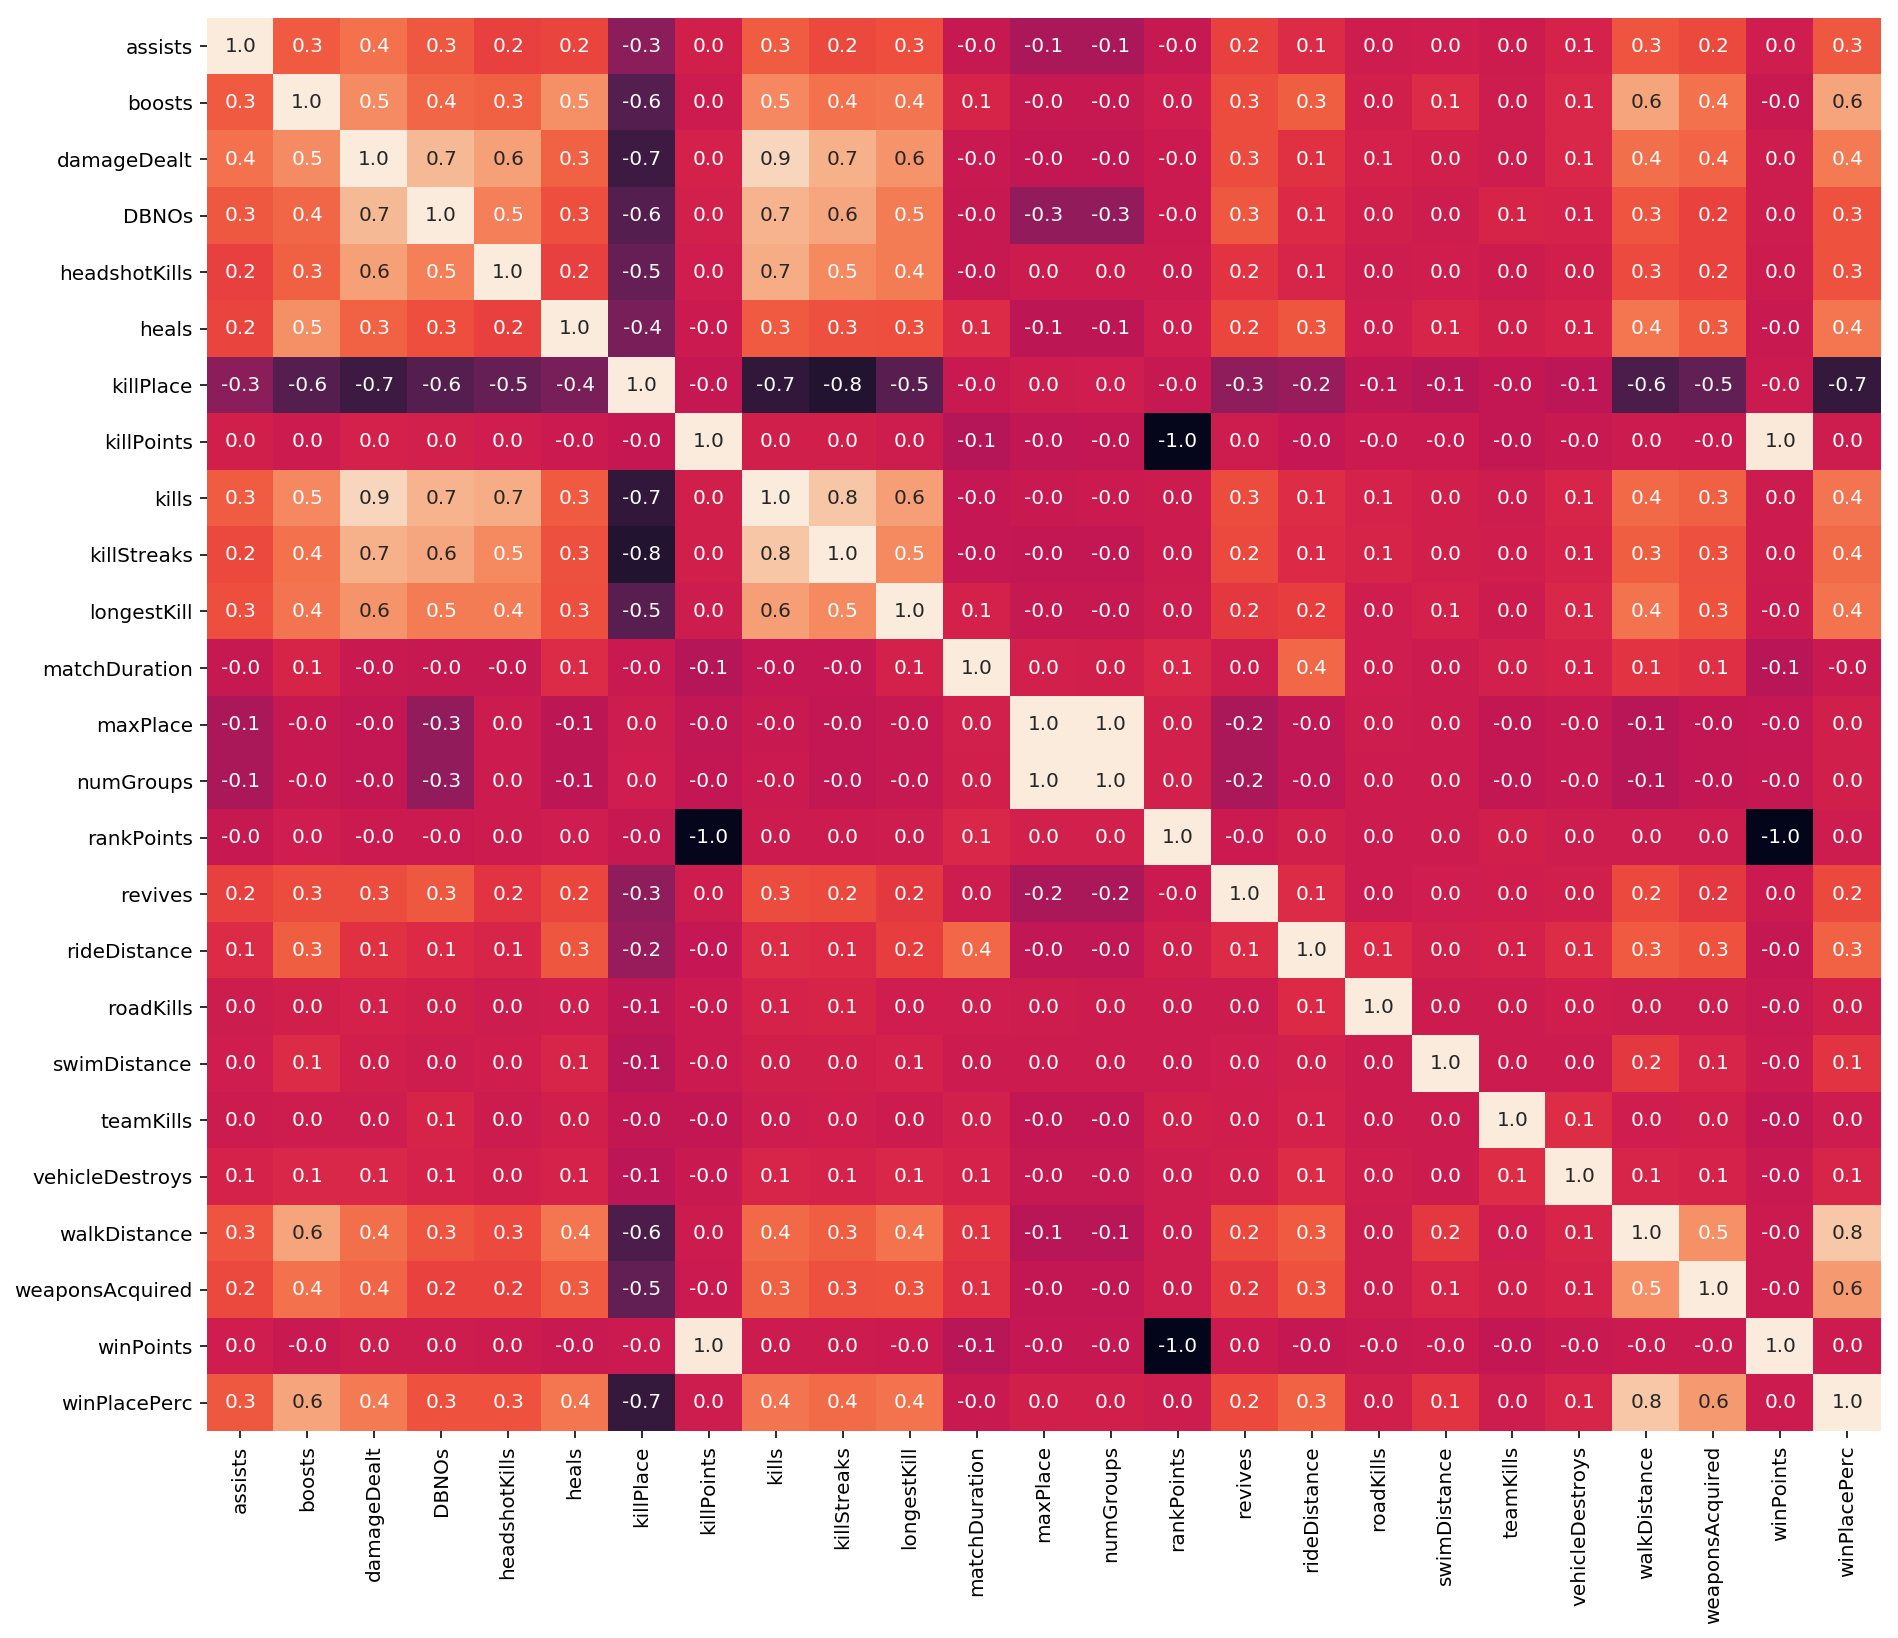

In [22]:
f,ax = plt.subplots(figsize=(15, 13))
sns.heatmap(train.corr(), annot=True, fmt= '.1f',ax=ax,cbar=False)
plt.show()

Match Statistics

In [25]:
print("Number of match in the train dataset:",train['matchId'].nunique())

Number of match in the train dataset: 47965


Text(0.5, 1.0, 'Number of players Joined')

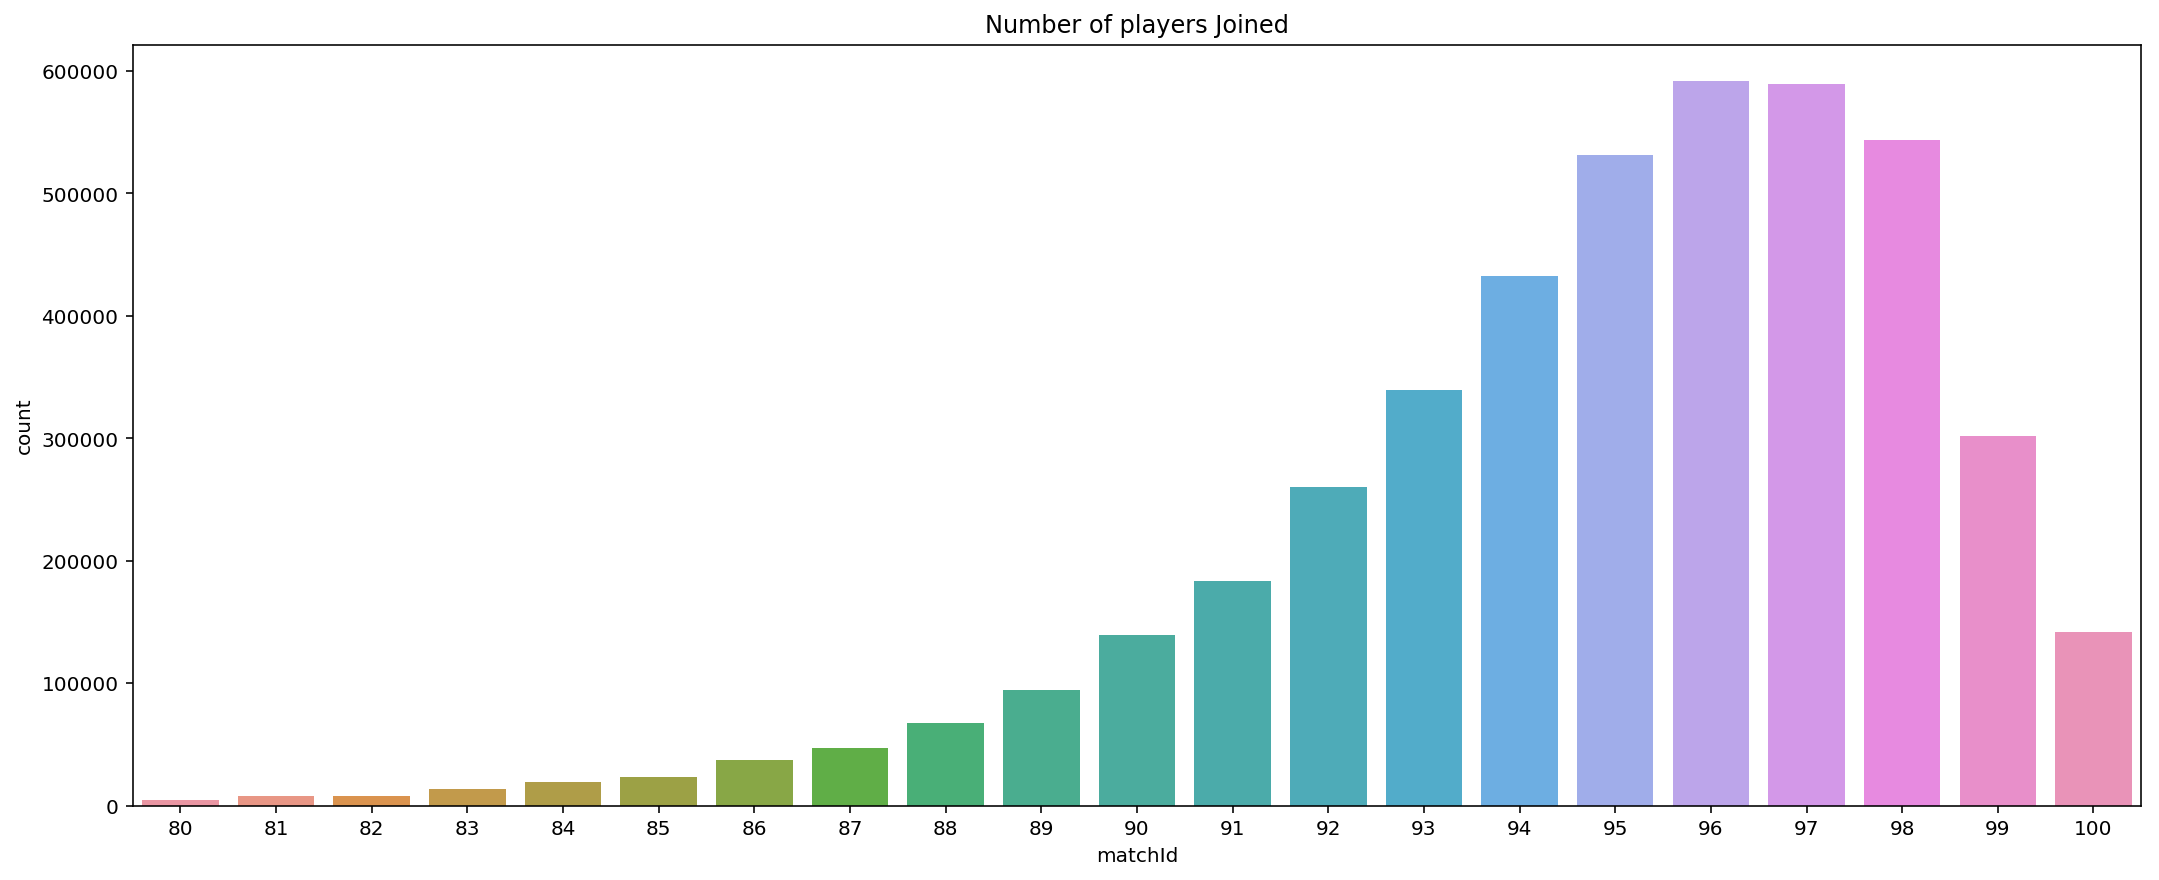

In [27]:
plt.rcParams['figure.figsize'] = 18,7
players = train.groupby('matchId')['matchId'].transform('count')
sns.countplot(players[players>=80])
plt.title('Number of players Joined')

## Data Processing

In next steps we will create new features.

New features:
- __kill_rank_point__ - Number of points in rank games. <br>
- __headshot_rate__ - Head shot rate in the game. <br>
- __kills_assists__ - Kills + assists. <br>
- __heals_boosts__ - Heals + boots usage. <br>
- __total_distance__ - Total distance traveled in a game, inluding walking distance, swimming distance, and riding distance. <br>
- __total_items_acquired__ - Number of all items acquired. <br>
- __distance_over_weapons__ - Ratio of distance traveled versus weapons acquired . <br>
- __walkDistance_over_heals__ - Ratio of walking distance versus heals done. <br>
- __walkDistance_over_kills__ - Ratio of walking distance versus kills done. <br>
- __killsPerWalkDistance__ - Ratio of kills versus walking distance. <br>
- __skill__ - Headshot kills + ridekilss. <br>
- __damageRate__ - kills/0.01* damageDealt. <br>
- __killStreakRate__ - killStreaks / kills. <br>
- __healsOnKill__ - healthItems / kills. <br>
- __sniper__ - longestKill / 100* weaponsAcquired. <br>
- __totalDistancePen__ - rideDistance/5 + walkDistance + swimDistance*10. <br>
- __killsPerRoadDist__ - longestKill / 100* weaponsAcquired. <br>
- __killsPerRoadDist__ - roadKills / rideDistance. <br>
- __killsPerDist__ - kills / total_distance. <br>


In [131]:
def feature_pubg(is_train):
    test_idx = None
    if is_train: 
        df = pd.read_csv('train_V2.csv') 
        df = df[df['maxPlace'] > 1]
        df = df[df['winPlacePerc'].notnull()]
    else:
        df = pd.read_csv('test_V2.csv') 
        test_idx = df.Id
        
    
    
    target = 'winPlacePerc'
    
    team_features = {
        'assists': [sum, np.mean, np.size], #np.size - size of team
        'boosts' : [sum, np.var, np.mean], 
        'heals': [sum, np.var, np.mean],
        'damageDealt': [np.var,min,max,np.mean],
        'DBNOs': [np.var,max,np.mean],
        'headshotKills': [max,np.mean],

        'kills': [sum, max, np.var,np.mean],
        'killStreaks': [max,np.var,np.mean],
        'longestKill': [max, np.mean, np.var],
        'revives': sum,
        'rideDistance': [sum, np.mean,np.var],
        'swimDistance': [np.var],
        'teamKills': sum,
        'vehicleDestroys': sum,
        'walkDistance': [np.var,np.mean],
        'weaponsAcquired': [np.mean],
        'damageRate': [np.var,min,max,np.mean],
        'headshotRate': [np.var,max,np.mean],
        'killStreakRate': [np.var,np.max, np.mean],
        'healthItems': [np.var, np.mean],
        'healsOnKill': [ np.var, np.mean],
        'sniper': [ np.var, np.mean],
        'kills_assists':sum,
        'heals_boosts':sum,
        'totalDistancePen': [ sum ,np.var, np.mean],
        'killsPerRoadDist': [np.mean],
        'killsPerWalkDist': [np.mean],
        'killsPerDist': [np.mean],
        'distance_over_weapons': [np.mean],
        'walkDistance_over_heals': [np.mean],
        'walkDistance_over_kills': [np.mean],
        'skill': [np.var,np.mean]
}
    
    
    print('Adding new features')
    df.loc[(df['rankPoints'] == -1), 'rankPoints'] = 0
    df['kill_rank_point'] = df['rankPoints']+df['killPoints']
    df['headshot_rate'] = df['headshotKills']/df['kills']
    df['kills_assists'] = df['kills']+df['assists']
    df['heals_boosts'] = df['heals']+df['boosts']
    df['total_distance'] = df['walkDistance'] +df['rideDistance'] + df['swimDistance']
    df['total_items_acquired'] = df['boosts'] + df['heals'] + df['weaponsAcquired']
    df['distance_over_weapons'] = df['total_distance'] / df['weaponsAcquired']
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
    df["skill"] = df["headshotKills"] + df["roadKills"]
    nplayers = df.groupby('matchId')['matchId'].transform('count')
    df['damageRate'] = df['kills']/(0.01*df['damageDealt'])
    df['headshotRate'] = df['headshotKills']/df['kills']
    df['killStreakRate'] = df['killStreaks']/df['kills']
    df['healthItems'] = df['heals'] + df['boosts']
    df['healsOnKill'] = df['healthItems']/df['kills']
    df['sniper'] = df['longestKill']/100*df['weaponsAcquired']
    df['totalDistancePen'] = df['rideDistance']/5 + df["walkDistance"] + df["swimDistance"]*10
    df['killsPerRoadDist'] = df['roadKills'] / (df['rideDistance']+1)
    df['killsPerWalkDist'] = (df['kills']-df['roadKills']) / (df['walkDistance']+1)
    df['killsPerDist'] = df['kills']/(df['total_distance']+1)



    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    df.fillna(0, inplace=True)
    ids = df[['matchId','groupId','Id']]
    df.drop(columns=['killPlace','killPoints','rankPoints',
                     'winPoints','matchType','maxPlace','Id'],inplace=True)
  
    tfeatures = team_features.copy()
    
    y = None
    
    if is_train:
        tfeatures['winPlacePerc'] = max
    X = df.groupby(['matchId','groupId']).agg(tfeatures)
    X.fillna(0,inplace=True)
    X.replace(np.inf, 1000000, inplace=True)
    X = reduce_mem_usage(X)    
    
    if is_train:
        y = X[('winPlacePerc','max')]     
        X.drop(columns=[('winPlacePerc','max')],inplace=True)
             
   
    #Group dataset by matches. To each match apply ranking 
    print("Group dataset by matches")
    X_ranked = X.groupby('matchId').rank(pct=True)    
    X = X.reset_index()[['matchId','groupId']].merge(X_ranked, suffixes=["", "_rank"], how='left', on=['matchId', 'groupId'] )

    ids_after = X[['matchId','groupId']]
    ids_after.columns = ['matchId','groupId']
    
    X = X.drop(['matchId','groupId'],axis=1)
    X.columns = [a+"_"+b for a,b in X.columns]
    X = reduce_mem_usage(X)

    return X, y, ids, ids_after

Train data Allocation

In [132]:
X_train, y, _, _ = feature_pubg(True)

Adding new features
Group dataset by matches


Test data Allocation

In [136]:
X_test, _,ids_init,ids_after = feature_pubg(False)

Adding new features
Group dataset by matches


In [137]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

Generate train and valiation set

In [159]:
train_index = round(int(X_train.shape[0]*0.8))
dev_X = X_train[:train_index] 
val_X = X_train[train_index:]
dev_y = y[:train_index] 
val_y = y[train_index:] 
gc.collect()

88

Defining and fitting our model:

In [160]:
def run_lgb(train_X, train_y, val_X, val_y, x_test):
    evals_result = {} 
    params = {"objective" : "regression", 
              "metric" : "mae", 
              'n_estimators':5000, 
              'early_stopping_rounds':200,
              "num_leaves" : 31, 
              "learning_rate" : 0.05, 
              "bagging_fraction" : 0.7,
              "bagging_seed" : 0, 
              "num_threads" : 4,
              "colsample_bytree" : 0.7
             }
    
    lgb_train = lgb.Dataset(train_X, label=train_y)
    lgb_val = lgb.Dataset(val_X, label=val_y)
    
    model = lgb.train(params, lgb_train, 
                      valid_sets=[lgb_train, lgb_val], 
                      early_stopping_rounds=200, 
                      verbose_eval=1000,
                      evals_result=evals_result)
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(x_tra, y_tra, x_val, y_val, X_test)

Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 0.0592533	valid_1's l1: 0.0599322
[2000]	training's l1: 0.0584516	valid_1's l1: 0.0596697
[3000]	training's l1: 0.0578248	valid_1's l1: 0.0595662
[4000]	training's l1: 0.0572623	valid_1's l1: 0.0595106
[5000]	training's l1: 0.0567436	valid_1's l1: 0.0594731
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0567436	valid_1's l1: 0.0594731


In [162]:
model.save_model('pugb_model.txt')

Import the Shap package to calcualte feature importance

In [166]:
shap.initjs()

SAMPLE_SIZE = 10000
SAMPLE_INDEX = np.random.randint(0, X_test.shape[0], SAMPLE_SIZE)

X = X_test.iloc[SAMPLE_INDEX]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [167]:
#I decide to save shap values, because running shap functions cost me a lot of time
np.save("shap_value", shap_values)

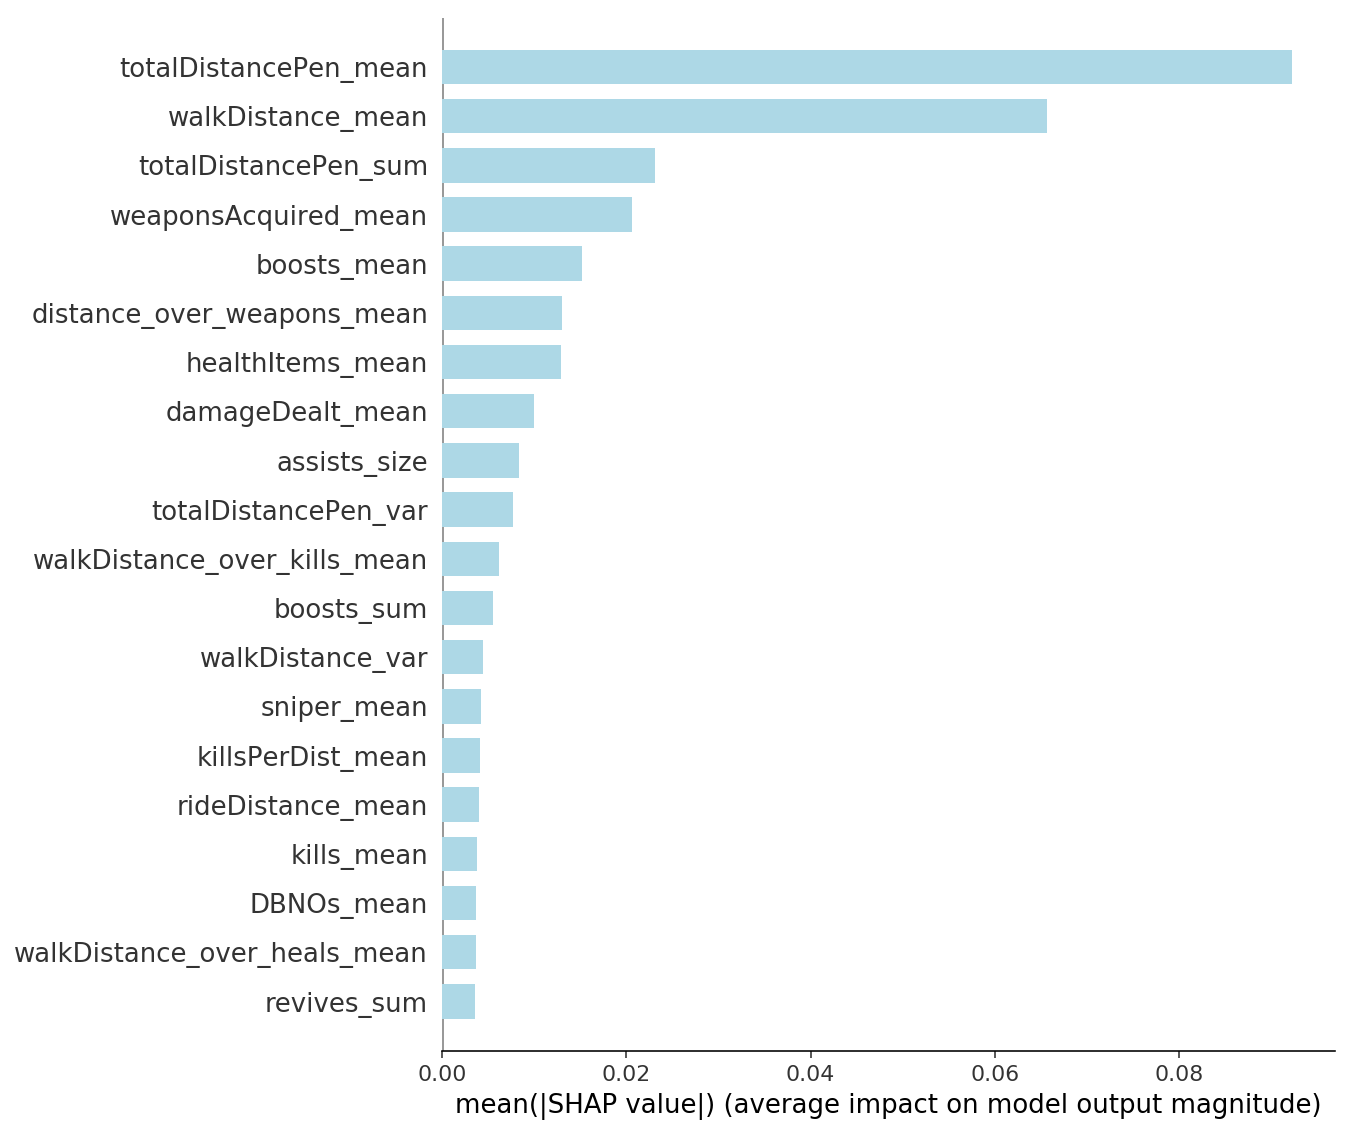

In [168]:
shap.summary_plot(shap_values, X, plot_type='bar', color='lightblue', show=False)
import matplotlib.pyplot as pl 
f = pl.gcf()
plt.savefig('feature_imp.png', dpi=1000, bbox_inches='tight')

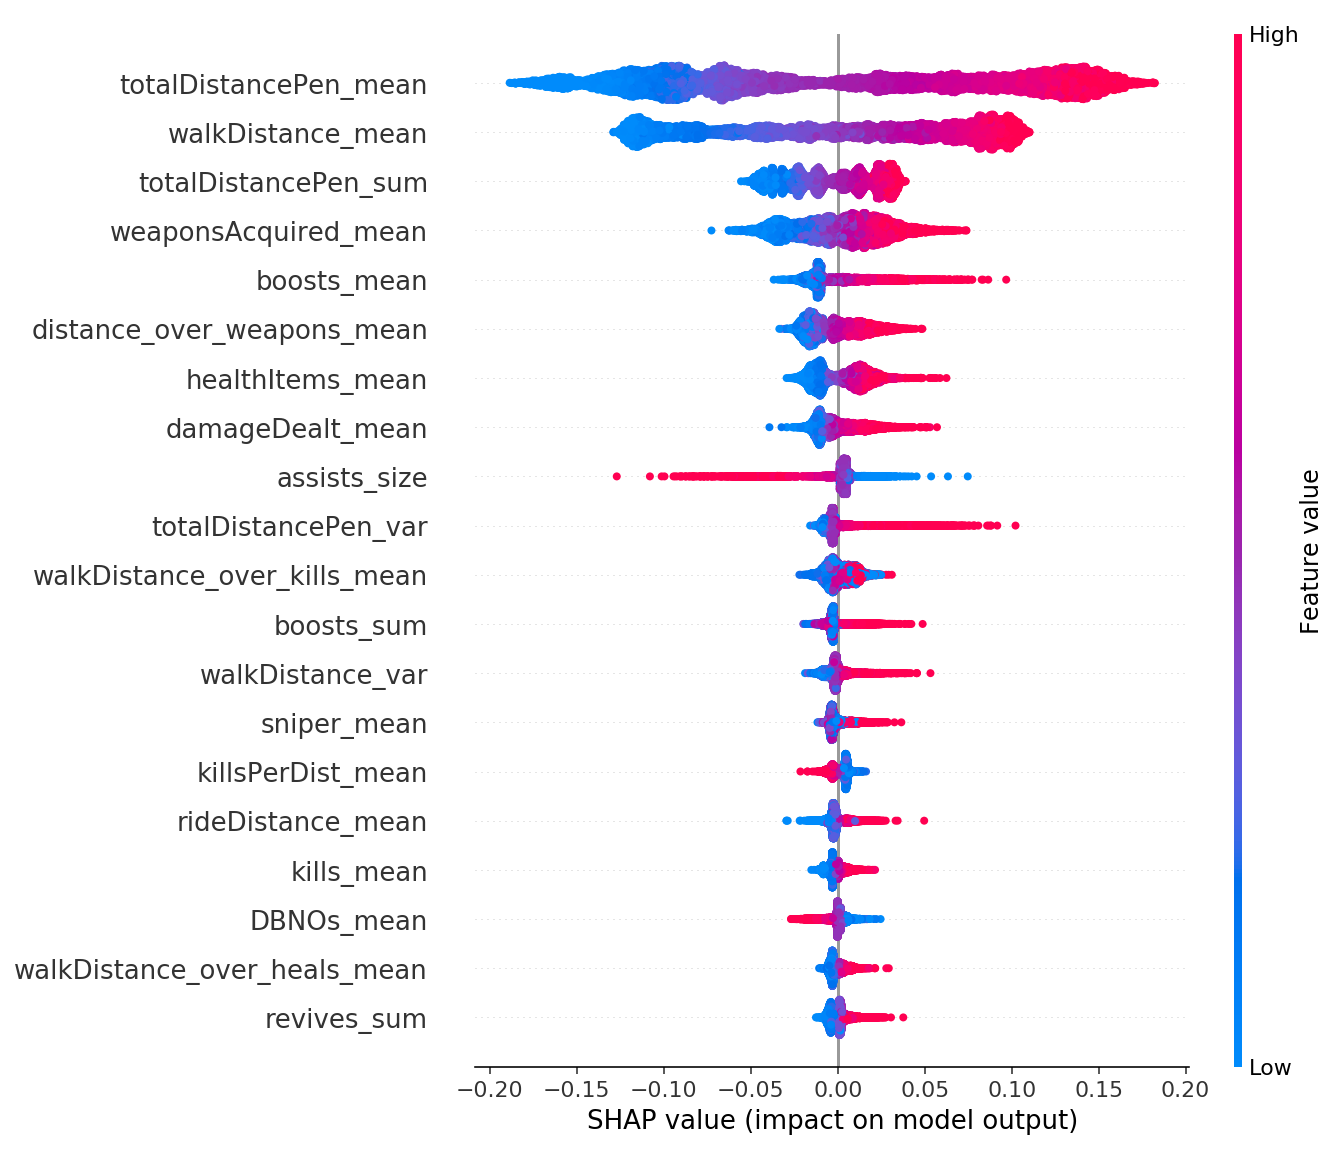

In [169]:
shap.summary_plot(shap_values, X)

We can see that total walking distance is the one mostly associated with winning placement. There are also some interesting features, like boos energy usage. It looks that players with higher usage of energy drink tend to have large probability of winning the game.

Other features, like number of weapons acquired and health Items usage do not surprise me. But I would not expect that number of kills at such a low rank. It looks that people enjoying too much kills sometimes won't win the game :P

## Submission

In [171]:
ids_after['winPlacePerc'] = pred_test
predict = ids_init.merge(ids_after, how='left', on=['groupId',"matchId"])['winPlacePerc']
df_sub = pd.read_csv("sample_submission_V2.csv")
df_test = pd.read_csv("test_V2.csv")
df_sub['winPlacePerc'] = predict
df_sub[["Id", "winPlacePerc"]].to_csv("submission.csv", index=False)
